# Unfair Classification Dataset Generation and Analysis

This tutorial demonstrates `make_unfair_classification`, an extension of
scikit-learn's `make_classification` that generates datasets with
built-in fairness considerations. Unlike the standard function, this
version creates datasets where different sensitive groups have different
characteristics, enabling the study of algorithmic bias.

## Overview

This notebook covers:
* **Dataset Generation**: Generating data with fairness constraints
* **Data Exploration**: Visualizing group-specific patterns
* **Model Training**: Training classifiers on the generated data
* **Fairness Analysis**: Evaluating performance disparities across groups.

### Key Functions Covered:
1. **`get_params_for_certain_equality_type`**: Automatically generates fairness scenario parameters
2. **`make_unfair_classification`**: Creates biased datasets (extends scikit-learn's make_classification)
3. **`visualize_groups_separately`**: Shows group data patterns
4. **`visualize_group_classes`**: Displays combined view with centroids
5. **`train_and_evaluate_model_with_classifier`**: Standard ML training with fairness evaluation
6. **`visualize_TPR_FPR_metrics`**: Compares key fairness metrics across groups
7. **`visualize_accuracy`**: Shows overall performance disparities

## Required Imports
The following imports are required for using the unfair classification generator and associated analysis tools:


In [1]:
import pandas as pd

from helpers import get_params_for_certain_equality_type
from unfair_classification import make_unfair_classification
from model_trainer import train_and_evaluate_model_with_classifier
from visualizer import (
    visualize_TPR_FPR_metrics, 
    visualize_accuracy, 
    visualize_groups_separately, 
    visualize_group_classes
    )

## Configuring Fairness Parameters

Before generating data, configure the dataset parameters.

**Key Parameters:**
- `n_samples`: Dataset size
- `n_features`: Total number of features
- `n_informative`: Number of features containing actual information
- `fairness_type`: Type of bias to simulate
- `sensitive_group_count`: Number of sensitive groups (must be between 2 and 5)

**Understanding `get_params_for_certain_equality_type`:**
This helper function automatically generates group-specific parameters for different
fairness scenarios:

* **"Equal quality"**

* **"Demographic parity"**

* **"Equal opportunity"**

* **"Equalized odds"**

**Sensitive Groups:**
Groups are represented using weather names: Sunny, Cloudy, Rainy, Windy, Stormy (depending on `sensitive_group_count`).

The function is optional, as the parameters can be specified manually in `make_unfair_classification` function.

In [2]:
# Dataset settings
n_samples = 5000
n_features = 10
n_classes = 2
n_informative = 3
random_state = 42

# Fairness type and groups
equality = "Demographic parity"
sensitive_group_count = 3
group_params = get_params_for_certain_equality_type(equality, sensitive_group_count)
print(group_params)

{'Sunny': {'weights': [0.7, 0.3]}, 'Cloudy': {'weights': [0.2, 0.8]}, 'Rainy': {'weights': [0.4, 0.6]}}


## 2. Generating the Unfair Dataset

**Parameters:**
- `n_leaky`: Creates features that correlate with sensitive group membership (problematic for fairness)
- `fairness_type` (optional): Uses the previously defined fairness constraint type
- `n_sensitive_groups` (optional): Number of sensitive groups (must be between 2 and 5)
- `group_params` (optional): Applies the group-specific parameters
- `append_sensitive_to_X` (optional): Returns sensitive groups as separate array (mandatory for analysis)
- `return_sensitive_group_centroids` (optional): Returns cluster centers for visualization

**Returns:**
- **X**: Feature matrix of shape (n_samples, n_features)
- **y**: Binary target labels (0 or 1)
- **Z** (optional): Sensitive group assignments
- **group_centroids** (optional): Dictionary mapping groups to their cluster centers

In [3]:
X, y, Z, group_centroids = make_unfair_classification(
    n_samples=n_samples,
    n_features=n_features,
    n_informative=n_informative,
    random_state=random_state,
    n_classes=n_classes,
    n_leaky=2,
    fairness_type=equality,
    n_sensitive_groups=sensitive_group_count,
    group_params=group_params,
    append_sensitive_to_X=False,
    return_sensitive_group_centroids=True
)

df = pd.DataFrame(X)
df['y'] = y
df.head()

,0,1,2,3,4,5,6,7,8,9,y
0,-1.780144,-0.264731,-1.559164,-0.908596,3.084400,0.0,0.0,-0.052064,0.497749,0.510399,0
1,0.473752,0.388338,0.614978,0.634962,-0.979731,0.0,0.0,-2.204482,0.589394,0.581807,1
2,0.750344,1.207542,-0.346786,0.553567,-0.357122,0.0,0.0,-1.546003,0.584731,0.723223,1
3,0.419036,-0.706648,-0.270181,-0.844424,-0.206785,0.0,0.0,-0.324433,0.467705,0.599799,0
4,2.391458,0.787756,1.032774,0.821960,-3.185630,0.0,0.0,-0.501386,0.425977,0.465158,1


## Understanding the Generated Data

The generated dataset can be organized into a pandas DataFrame for analysis.
This step demonstrates how to identify and label the different types of features.

**Feature Structure:**
The feature matrix X contains different types of features (in this example):
- *Columns 0-2*: Informative features (contain actual predictive signal)
- *Columns 3-4*: Redundant features (linear combinations of informative features)
- *Columns 5-7*: Noise features (random values with no predictive power)
- *Columns 8-9*: Leaky features (correlate with sensitive groups)

**Feature Naming Convention:**
- Leaky features are renamed to 'l1' and 'l2' for easy identification
- The target variable is labeled 'y'

In [4]:
cols = list(df.columns)
cols[-2] = 'l2'
cols[-3] = 'l1'
df.columns = [str(c) for c in cols]

df.head()

,0,1,2,3,4,5,6,7,l1,l2,y
0,-1.780144,-0.264731,-1.559164,-0.908596,3.084400,0.0,0.0,-0.052064,0.497749,0.510399,0
1,0.473752,0.388338,0.614978,0.634962,-0.979731,0.0,0.0,-2.204482,0.589394,0.581807,1
2,0.750344,1.207542,-0.346786,0.553567,-0.357122,0.0,0.0,-1.546003,0.584731,0.723223,1
3,0.419036,-0.706648,-0.270181,-0.844424,-0.206785,0.0,0.0,-0.324433,0.467705,0.599799,0
4,2.391458,0.787756,1.032774,0.821960,-3.185630,0.0,0.0,-0.501386,0.425977,0.465158,1


## Visualizing Group-Specific Patterns

The `visualize_groups_separately` function creates individual scatter plots
for each sensitive group, helping identify group-specific data characteristics.

**Parameters:**
- **X, y, Z**: The generated dataset arrays
- **feature1, feature2** (optional): Specific features to plot (default: first and second feature)
- **feature1_name, feature2_name** (optional): Labels for the plot axes

{}

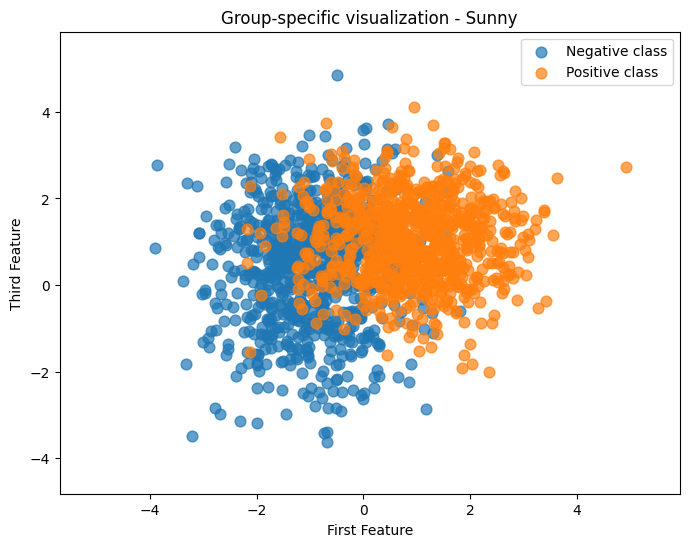

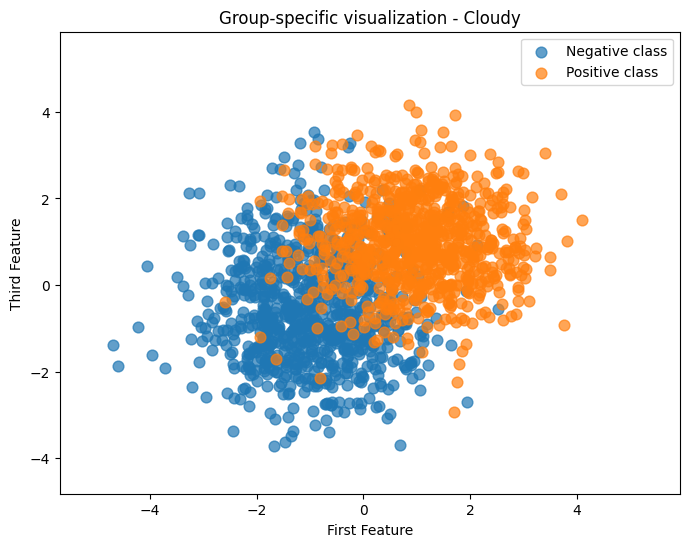

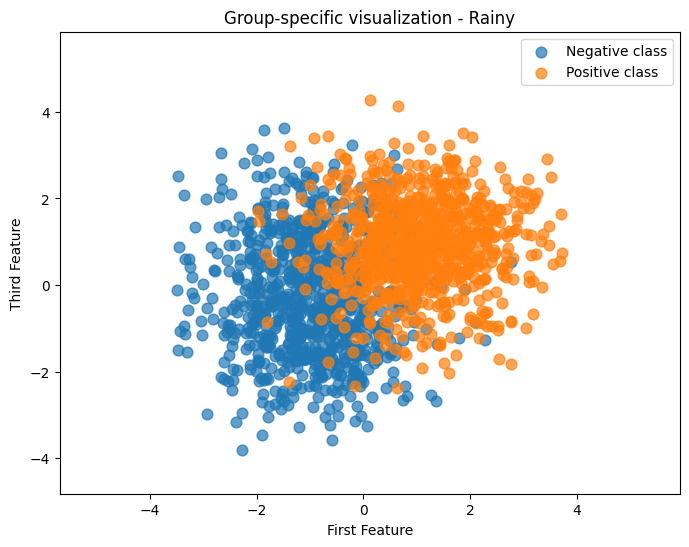

In [5]:
visualize_groups_separately(
    X,
    y,
    Z,
    feature1=X[:,0],
    feature2=X[:,2],
    feature1_name="First Feature",
    feature2_name="Third Feature"
    )

## Group Classes Visualization with Centroids

The `visualize_group_classes` function displays all groups in a single plot
with their cluster centroids, showing the overall data structure.

**Parameters:**
- **X, y, Z**: The generated dataset arrays
- **centroids**: Uses the returned centroid dictionary from make_unfair_classification
- **feature1, feature2** (optional): Specific features to plot (default: first and second feature)
- **feature1_name, feature2_name** (optional): Labels for the plot axes

<module 'matplotlib.pyplot' from 'c:\\Users\\tiazv\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\matplotlib\\pyplot.py'>

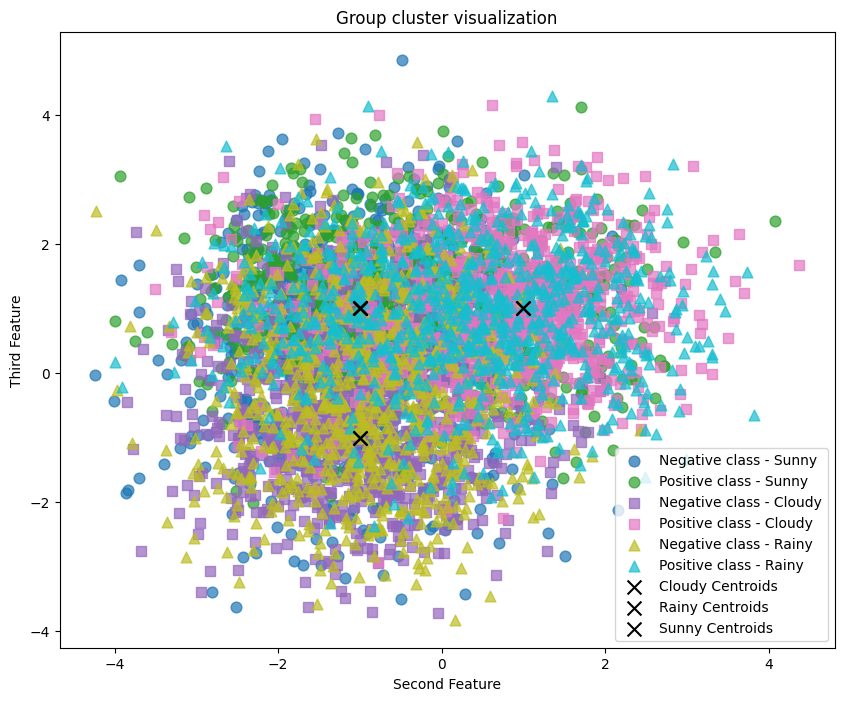

In [6]:
visualize_group_classes(
    X,
    y,
    Z,
    centroids=group_centroids,
    feature1=X[:,1],
    feature2=X[:,2],
    feature1_name="Second Feature",
    feature2_name="Third Feature",
    )

## Training and Evaluating for Fairness

The `train_and_evaluate_model_with_classifier` function trains a standard classifier (Random Forest)
and evaluates the performance across all sensitive groups.
Training is needed for functions `visualize_TPR_FPR_metrics` and `visualize_accuracy`.

**Parameters:**
- **X, y, Z**: The generated dataset arrays

In [7]:
metrics = train_and_evaluate_model_with_classifier(X, y, Z)
title = f"{equality} with {sensitive_group_count} sensitive groups"

## Analyzing Fairness Metrics

The `visualize_TPR_FPR_metrics` function creates bar charts comparing
True Positive Rate and False Positive Rate across groups.

**Parameters:**
- **`metrics`**: the metrics dictionary returned by the training function
- **`title`** (optional): title of the plot

<module 'matplotlib.pyplot' from 'c:\\Users\\tiazv\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\matplotlib\\pyplot.py'>

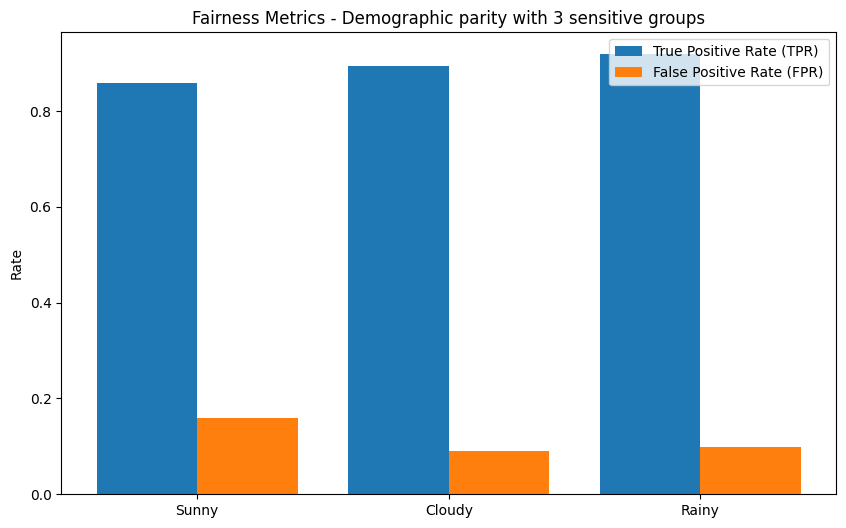

In [8]:
visualize_TPR_FPR_metrics(metrics, title)

## Comparing Overall Accuracy

The `visualize_accuracy` function shows overall prediction accuracy for each sensitive group.

**Parameters:**
- **`metrics`**: the metrics dictionary returned by the training function
- **`title`** (optional): title of the plot


<module 'matplotlib.pyplot' from 'c:\\Users\\tiazv\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\matplotlib\\pyplot.py'>

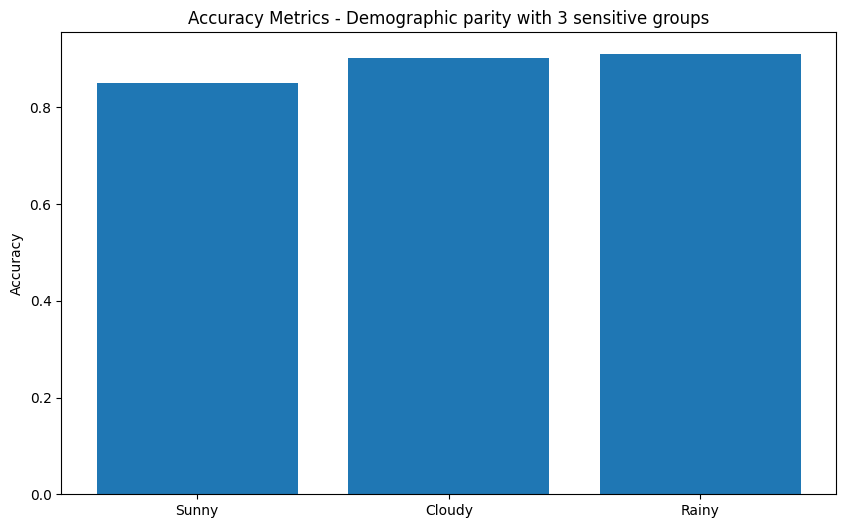

In [9]:
visualize_accuracy(metrics, title)